In [1]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Data Exploation
LB - FHR baseline (beats per minute) <br>
AC - # of accelerations per second <br> 
FM - # of fetal movements per second <br> 
UC - # of uterine contractions per second <br> 
DL - # of light decelerations per second <br> 
DS - # of severe decelerations per second <br> 
DP - # of prolongued decelerations per second <br> 
ASTV - percentage of time with abnormal short term variability <br> 
MSTV - mean value of short term variability <br> 
ALTV - percentage of time with abnormal long term variability <br> 
MLTV - mean value of long term variability <br> 
Width - width of FHR histogram <br> 
Min - minimum of FHR histogram <br> 
Max - Maximum of FHR histogram <br> 
Nmax - # of histogram peaks <br> 
Nzeros - # of histogram zeros <br> 
Mode - histogram mode <br> 
Mean - histogram mean <br> 
Median - histogram median <br> 
Variance - histogram variance <br> 
Tendency - histogram tendency <br> 
CLASS - FHR pattern class code (1 to 10) <br> 
__NSP - fetal state class code (N=normal; S=suspect; P=pathologic)__<br> 



In [2]:
train = pd.read_csv("/home/kaiyuewang/Machine-Learning/fetal-hr.csv")
# since the goal of this experienment is just to analyze the fetal state (ie. N, S, P). We will drop unncessary features to reduce complexity of the data
train = train.drop(['Unnamed: 9', 'Unnamed: 31', 'Unnamed: 42', 'Unnamed: 44', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS'], axis=1)
train = train.drop(train.index[2126:])
train['Time'] = train['e'].sub(train['b'], axis=0)
train = train.drop(['b', 'e'], axis=1)  # instead of using start and end feature, we can reduce the feature dimensionality by just calculating the interval

print (train.columns)  # number of features available


Index(['AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR', 'LB', 'AC.1', 'FM.1', 'UC.1',
       'DL.1', 'DS.1', 'DP.1', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min',
       'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance',
       'Tendency', 'NSP', 'Time'],
      dtype='object')


In [3]:
import sklearn
list_to_normalize = list(set(train.columns.values) - set(['NSP']))
y = train['NSP'].values
X = train[list_to_normalize].values
print (X.shape, y.shape)


(2126, 29) (2126,)


In [4]:
def accuracies_vs_trainsize(X_train, y_train, X_test, y_test, classifier_creation_func, accuracy_evaluation_func):
    training_accuracies = []
    testing_accuracies = []
    size_training = [X_train.shape[0] // i for i in range(5, 0, -1)] # sample 5 equally divided datapoints length
    indexes = [np.random.choice(X_train.shape[0], n, replace=False) for n in size_training]
    for index in indexes:
        print ("====================== {} ===============".format(index.shape))
        
        classifier = classifier_creation_func()
        xtrain = X_train[index]
        ytrain = y_train[index]
                
        training_accuracy, predict_accuracy = accuracy_evaluation_func(xtrain, ytrain, X_test, y_test, classifier)
        
        training_accuracies.append(training_accuracy)
        testing_accuracies.append(predict_accuracy)
    
    # plot the size vs accuracy data
    plt.plot(size_training, training_accuracies)
    plt.plot(size_training, testing_accuracies)
    plt.legend(['training_accuracy', 'testing_accuracy'])
    plt.ylabel('accuracies')
    plt.xlabel('train size')

# Ada Boost

In [42]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from subprocess import check_output
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# experienment on the best hyper parameters

In [73]:
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, ), n_estimators=400, algorithm="SAMME.R", learning_rate=0.05)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.9388714733542319

====================== (297,) ===============
====================== (372,) ===============
====================== (496,) ===============
====================== (744,) ===============
====================== (1488,) ===============


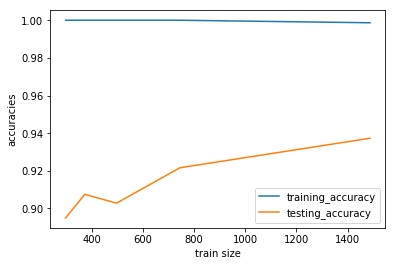

In [79]:
# test on the accuracy vs train size graph
def accuracy_evaluation(xtrain, ytrain, xtest, ytest, classifier):
    classifier.fit(xtrain, ytrain)
    train_acc = metrics.accuracy_score(classifier.predict(xtrain), ytrain)
    test_acc = metrics.accuracy_score(classifier.predict(X_test), y_test)
    return train_acc, test_acc

def classifier_generator():
    return AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, ), n_estimators=400, algorithm="SAMME.R", learning_rate=0.05)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)    
accuracies_vs_trainsize(X_train, y_train, X_test, y_test, classifier_generator, accuracy_evaluation)


In [78]:
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, ), n_estimators=40000, algorithm="SAMME.R", learning_rate=0.05)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.7601880877742947

# Neural Network

In [6]:
# Neural Network
from keras import models
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
import livelossplot
from sklearn.preprocessing import LabelBinarizer, StandardScaler
plot_losses = livelossplot.PlotLossesKeras()
%matplotlib inline

def classifier_generator(learn_rate=0.01):
    model = models.Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1], )))
#     model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    # model.add(Dense(64, activation='relu'))

    # model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    opt = Adam(lr=learn_rate)

    # Compile model
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Categorically encode labels
lb = LabelBinarizer()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# scale the data
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)


# Grid search Hyper parameter
param_grid = {"learn_rate": [0.05, 0.005, 0.0005],
             "batch_size": [16, 32, 48],
             }

model = KerasClassifier(build_fn=classifier_generator, epochs=20, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# # Check state of datase
# learning_rate = 0.00005
# EPOCHS = 20
# BATCH_SIZE = 1000

Using TensorFlow backend.


NameError: name 'GridSearchCV' is not defined

In [43]:
print (grid_result.best_params_)

{'batch_size': 16, 'learn_rate': 0.005}


====================== (297,) ===============
638/638 [==============================] - 0s 37us/step
====================== (372,) ===============
638/638 [==============================] - 0s 65us/step
====================== (496,) ===============
638/638 [==============================] - 0s 36us/step
====================== (744,) ===============
638/638 [==============================] - 0s 41us/step
====================== (1488,) ===============
638/638 [==============================] - 0s 52us/step


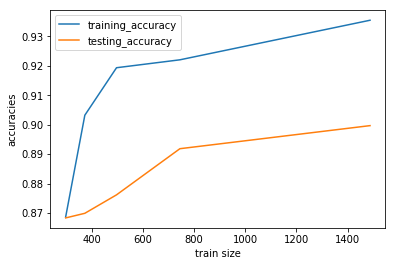

In [46]:
import functools
def accuracy_evaluation(xtrain, ytrain, xtest, ytest, classifier):
    classifier.fit(xtrain, ytrain, batch_size=80, epochs=16, verbose=0, validation_data=(X_test, y_test))
    return classifier.evaluate(xtrain, ytrain)[1], classifier.evaluate(X_test, y_test)[1]


accuracies_vs_trainsize(X_train, y_train, X_test, y_test, functools.partial(classifier_generator, 0.005), accuracy_evaluation)


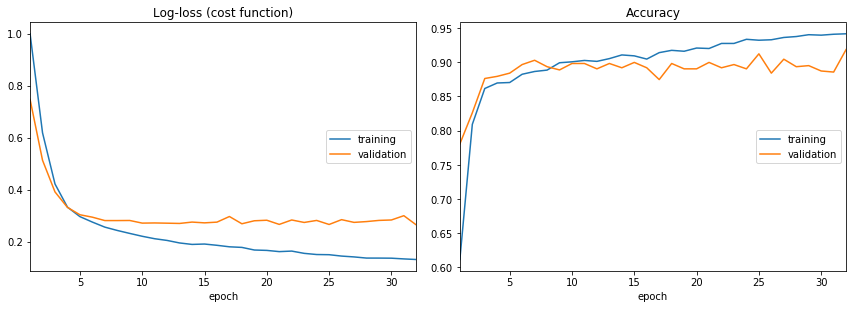

Log-loss (cost function):
training   (min:    0.132, max:    1.000, cur:    0.132)
validation (min:    0.265, max:    0.747, cur:    0.265)

Accuracy:
training   (min:    0.612, max:    0.942, cur:    0.942)
validation (min:    0.781, max:    0.918, cur:    0.918)


In [45]:
# Categorically encode labels
lb = LabelBinarizer()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# scale the data
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

classifier = classifier_generator(learn_rate=0.005)
classifier.fit(X_train, y_train, batch_size=100, epochs=32, verbose=0, callbacks=[plot_losses], validation_data=(X_test, y_test))

# Decision Tree

In [41]:
from sklearn import tree
from IPython.display import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree._tree import TREE_LEAF
from scipy.stats import randint

y = train['NSP'].values
X = train[list_to_normalize].values
print (X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Z score standardizaition making the dataset zero mean 
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": range(1, 12),
              "criterion": [ "entropy", "gini"]}


# Instantiate a Decision Tree classifier: tree
dctree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(dctree, param_dist, cv=5, return_train_score=True)

# Fit it to the data
tree_cv.fit(X_train, y_train)

print (tree_cv.best_params_)
print (tree_cv.best_score_)


(2126, 29) (2126,)
{'criterion': 'entropy', 'max_depth': 9}
0.926747311827957


====================== (297,) ===============
====================== (372,) ===============
====================== (496,) ===============
====================== (744,) ===============
====================== (1488,) ===============


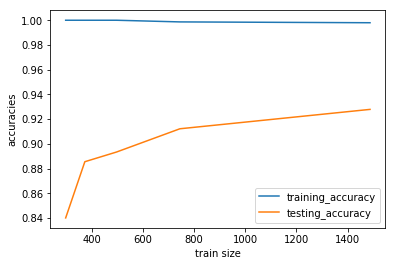

In [40]:
def classifier_generator():
    return tree.DecisionTreeClassifier(max_depth=12, criterion='gini')

def accuracy_evaluation(xtrain, ytrain, xtest, ytest, classifier):
    classifier.fit(xtrain, ytrain)
    train_accuracy = metrics.accuracy_score(classifier.predict(xtrain), ytrain)
    test_accuracy = metrics.accuracy_score(classifier.predict(xtest), ytest)
    return train_accuracy, test_accuracy

accuracies_vs_trainsize(X_train, y_train, X_test, y_test, classifier_generator, accuracy_evaluation)



82


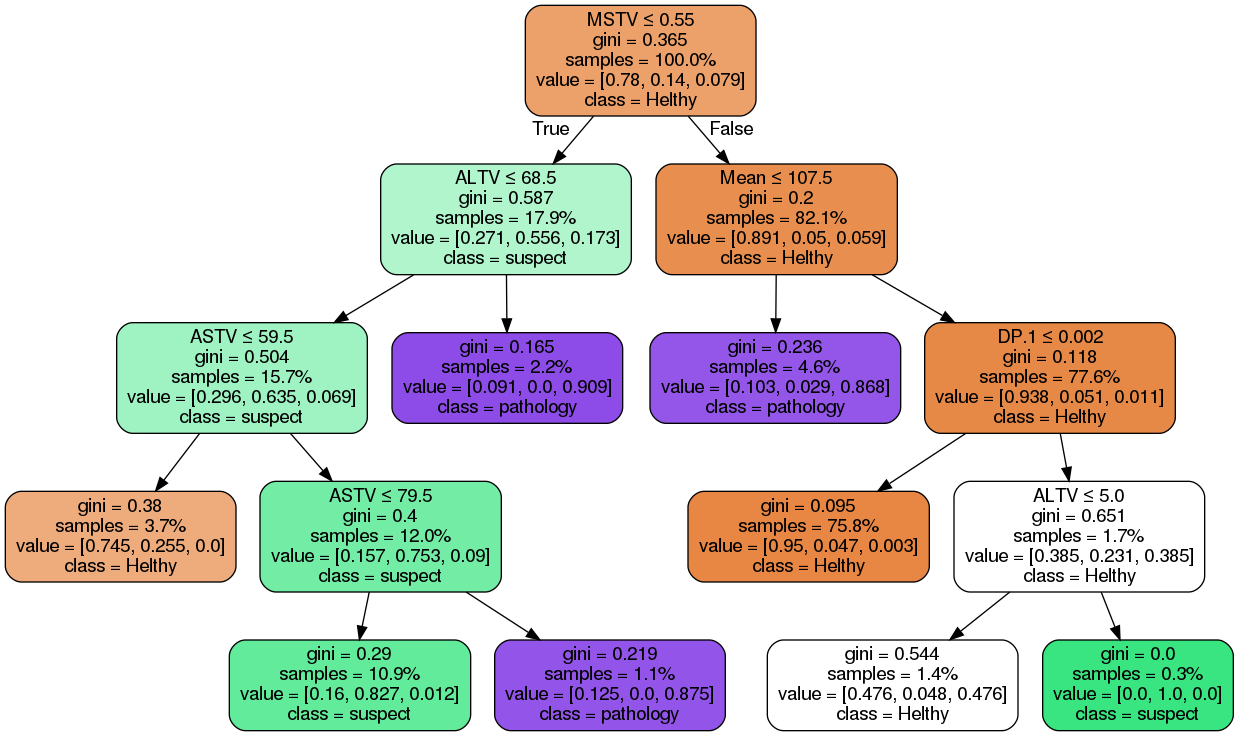

In [201]:
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

clf = classifier_generator()
clf.fit(X_train, y_train)
print(sum(clf.tree_.children_left < 0))
# start pruning from the root
# prune_index(clf.tree_, 0, 5)
# sum(clf.tree_.children_left < 0)

def plot_tree(clf,feature_names):
    tree.export_graphviz(clf,out_file='tree.dot',class_names=['Helthy','suspect', 'pathology'],feature_names=feature_names, 
                         filled=True, rounded=True, special_characters=True, proportion=True)
    os.system("dot -Tpng tree.dot -o tree.png")
    os.system("tree.png")
plot_tree(clf, list_to_normalize)
# Note : Uncoverted Quotes (Yes) and Converted quotes (No)
Image(filename='tree.png')

In [202]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9247648902821317

# KNN

In [184]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import datasets
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn
from multiprocessing import Process, Queue, Lock

# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Z score standardizaition making the dataset zero mean 
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

def K_nearest_neighbors(K):
#     lock.acquire()
#     try:
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=K)
    model.fit(X_train, y_train)

    # evaluate the model and update the accuracies list
    score = model.score(X_test, y_test)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
#     accuracies.put(score)
#     finally:
#         lock.release()

processes = [] 
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in range(1, 30, 2):
    p = Process(target=K_nearest_neighbors, args=(k,))
    processes.append(p)
    p.start()

for i in processes:
    i.join()

k=1, accuracy=89.66%
k=3, accuracy=90.44%
k=5, accuracy=90.28%
k=7, accuracy=91.07%
k=9, accuracy=90.44%
k=11, accuracy=89.97%
k=13, accuracy=90.91%
k=15, accuracy=90.13%
k=17, accuracy=89.81%
k=19, accuracy=89.81%
k=21, accuracy=88.87%
k=23, accuracy=88.71%
k=25, accuracy=89.03%
k=27, accuracy=88.40%
k=29, accuracy=88.09%


====================== (297,) ===============
====================== (372,) ===============
====================== (496,) ===============
====================== (744,) ===============
====================== (1488,) ===============


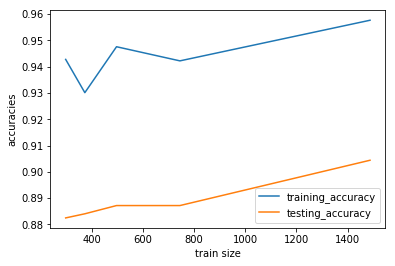

In [185]:
def create_classifier():
    return KNeighborsClassifier(n_neighbors=3)

def evaluate_classifier(trainX, trainY, testX, testY, classifier):
    classifier.fit(trainX, trainY)
    return classifier.score(trainX, trainY), classifier.score(testX, testY)

accuracies_vs_trainsize(X_train, y_train, X_test, y_test, create_classifier, evaluate_classifier)

# SVM

In [13]:
# SVM Helper
#https://github.com/ksopyla/svm_mnist_digit_classification/blob/master/mnist_helpers.py

# Standard scientific Python imports
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

# initialize the values of k for our k-Nearest Neighbor classifier along with the
# list of accuracies for each value of k
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Z score standardizaition making the dataset zero mean 
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots confusion matrix, 
    
    cm - confusion matrix
    """
    plt.figure(1, figsize=(15, 12), dpi=160)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    
    


class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_param_space_scores(scores, C_range, gamma_range):
    """
    Draw heatmap of the validation accuracy as a function of gamma and C
    
    
    Parameters
    ----------
    scores - 2D numpy array with accuracies
    
    """
    #
    # The score are encoded as colors with the hot colormap which varies from dark
    # red to bright yellow. As the most interesting scores are all located in the
    # 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
    # as to make it easier to visualize the small variations of score values in the
    # interesting range while not brutally collapsing all the low score values to
    # the same color.

    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.jet,
               norm=MidpointNormalize(vmin=0.5, midpoint=0.9))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')
    plt.show()

# SVM

In [10]:
# SVM
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
#fetch original mnist dataset

############### Classification with grid search ##############
# If you don't want to wait, comment this section and uncommnet section below with
# standalone SVM classifier

# Warning! It takes really long time to compute this about 2 days

# Create parameters grid for RBF kernel, we have to set C and gamma
from sklearn.model_selection import GridSearchCV

# generate matrix with all gammas
# [ [10^-4, 2*10^-4, 5*10^-4], 
#   [10^-3, 2*10^-3, 5*10^-3],
#   ......
#   [10^3, 2*10^3, 5*10^3] ]
#gamma_range = np.outer(np.logspace(-4, 3, 8),np.array([1,2, 5]))
gamma_range = np.outer(np.logspace(-3, 0, 4),np.array([1,5]))
gamma_range = gamma_range.flatten()

# generate matrix with all C
#C_range = np.outer(np.logspace(-3, 3, 7),np.array([1,2, 5]))
C_range = np.outer(np.logspace(-1, 1, 3),np.array([1,5]))
# flatten matrix, change to 1D numpy array
C_range = C_range.flatten()

parameters = {'kernel':['rbf'], 'C':C_range, 'gamma': gamma_range}

svm_clsf = svm.SVC()
grid_clsf = GridSearchCV(estimator=svm_clsf,param_grid=parameters,n_jobs=1, verbose=2)


start_time = dt.datetime.now()
print('Start param searching at {}'.format(str(start_time)))

grid_clsf.fit(X_train, y_train)

elapsed_time= dt.datetime.now() - start_time
print('Elapsed time, param searching {}'.format(str(elapsed_time)))
sorted(grid_clsf.cv_results_.keys())

classifier = grid_clsf.best_estimator_
params = grid_clsf.best_params_



scores = grid_clsf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plot_param_space_scores(scores, C_range, gamma_range)

Start param searching at 2019-02-10 14:15:27.566644
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.005, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.005, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.005, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.005, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.005, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.005, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=0.1, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

KeyboardInterrupt: 

Classification report for classifier SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        1.0       0.86      0.95      0.90       494
        2.0       0.57      0.47      0.51        86
        3.0       0.90      0.33      0.48        58

avg / total       0.82      0.83      0.81       638


Confusion matrix:
[[470  22   2]
 [ 46  40   0]
 [ 31   8  19]]
Accuracy=0.829153605015674


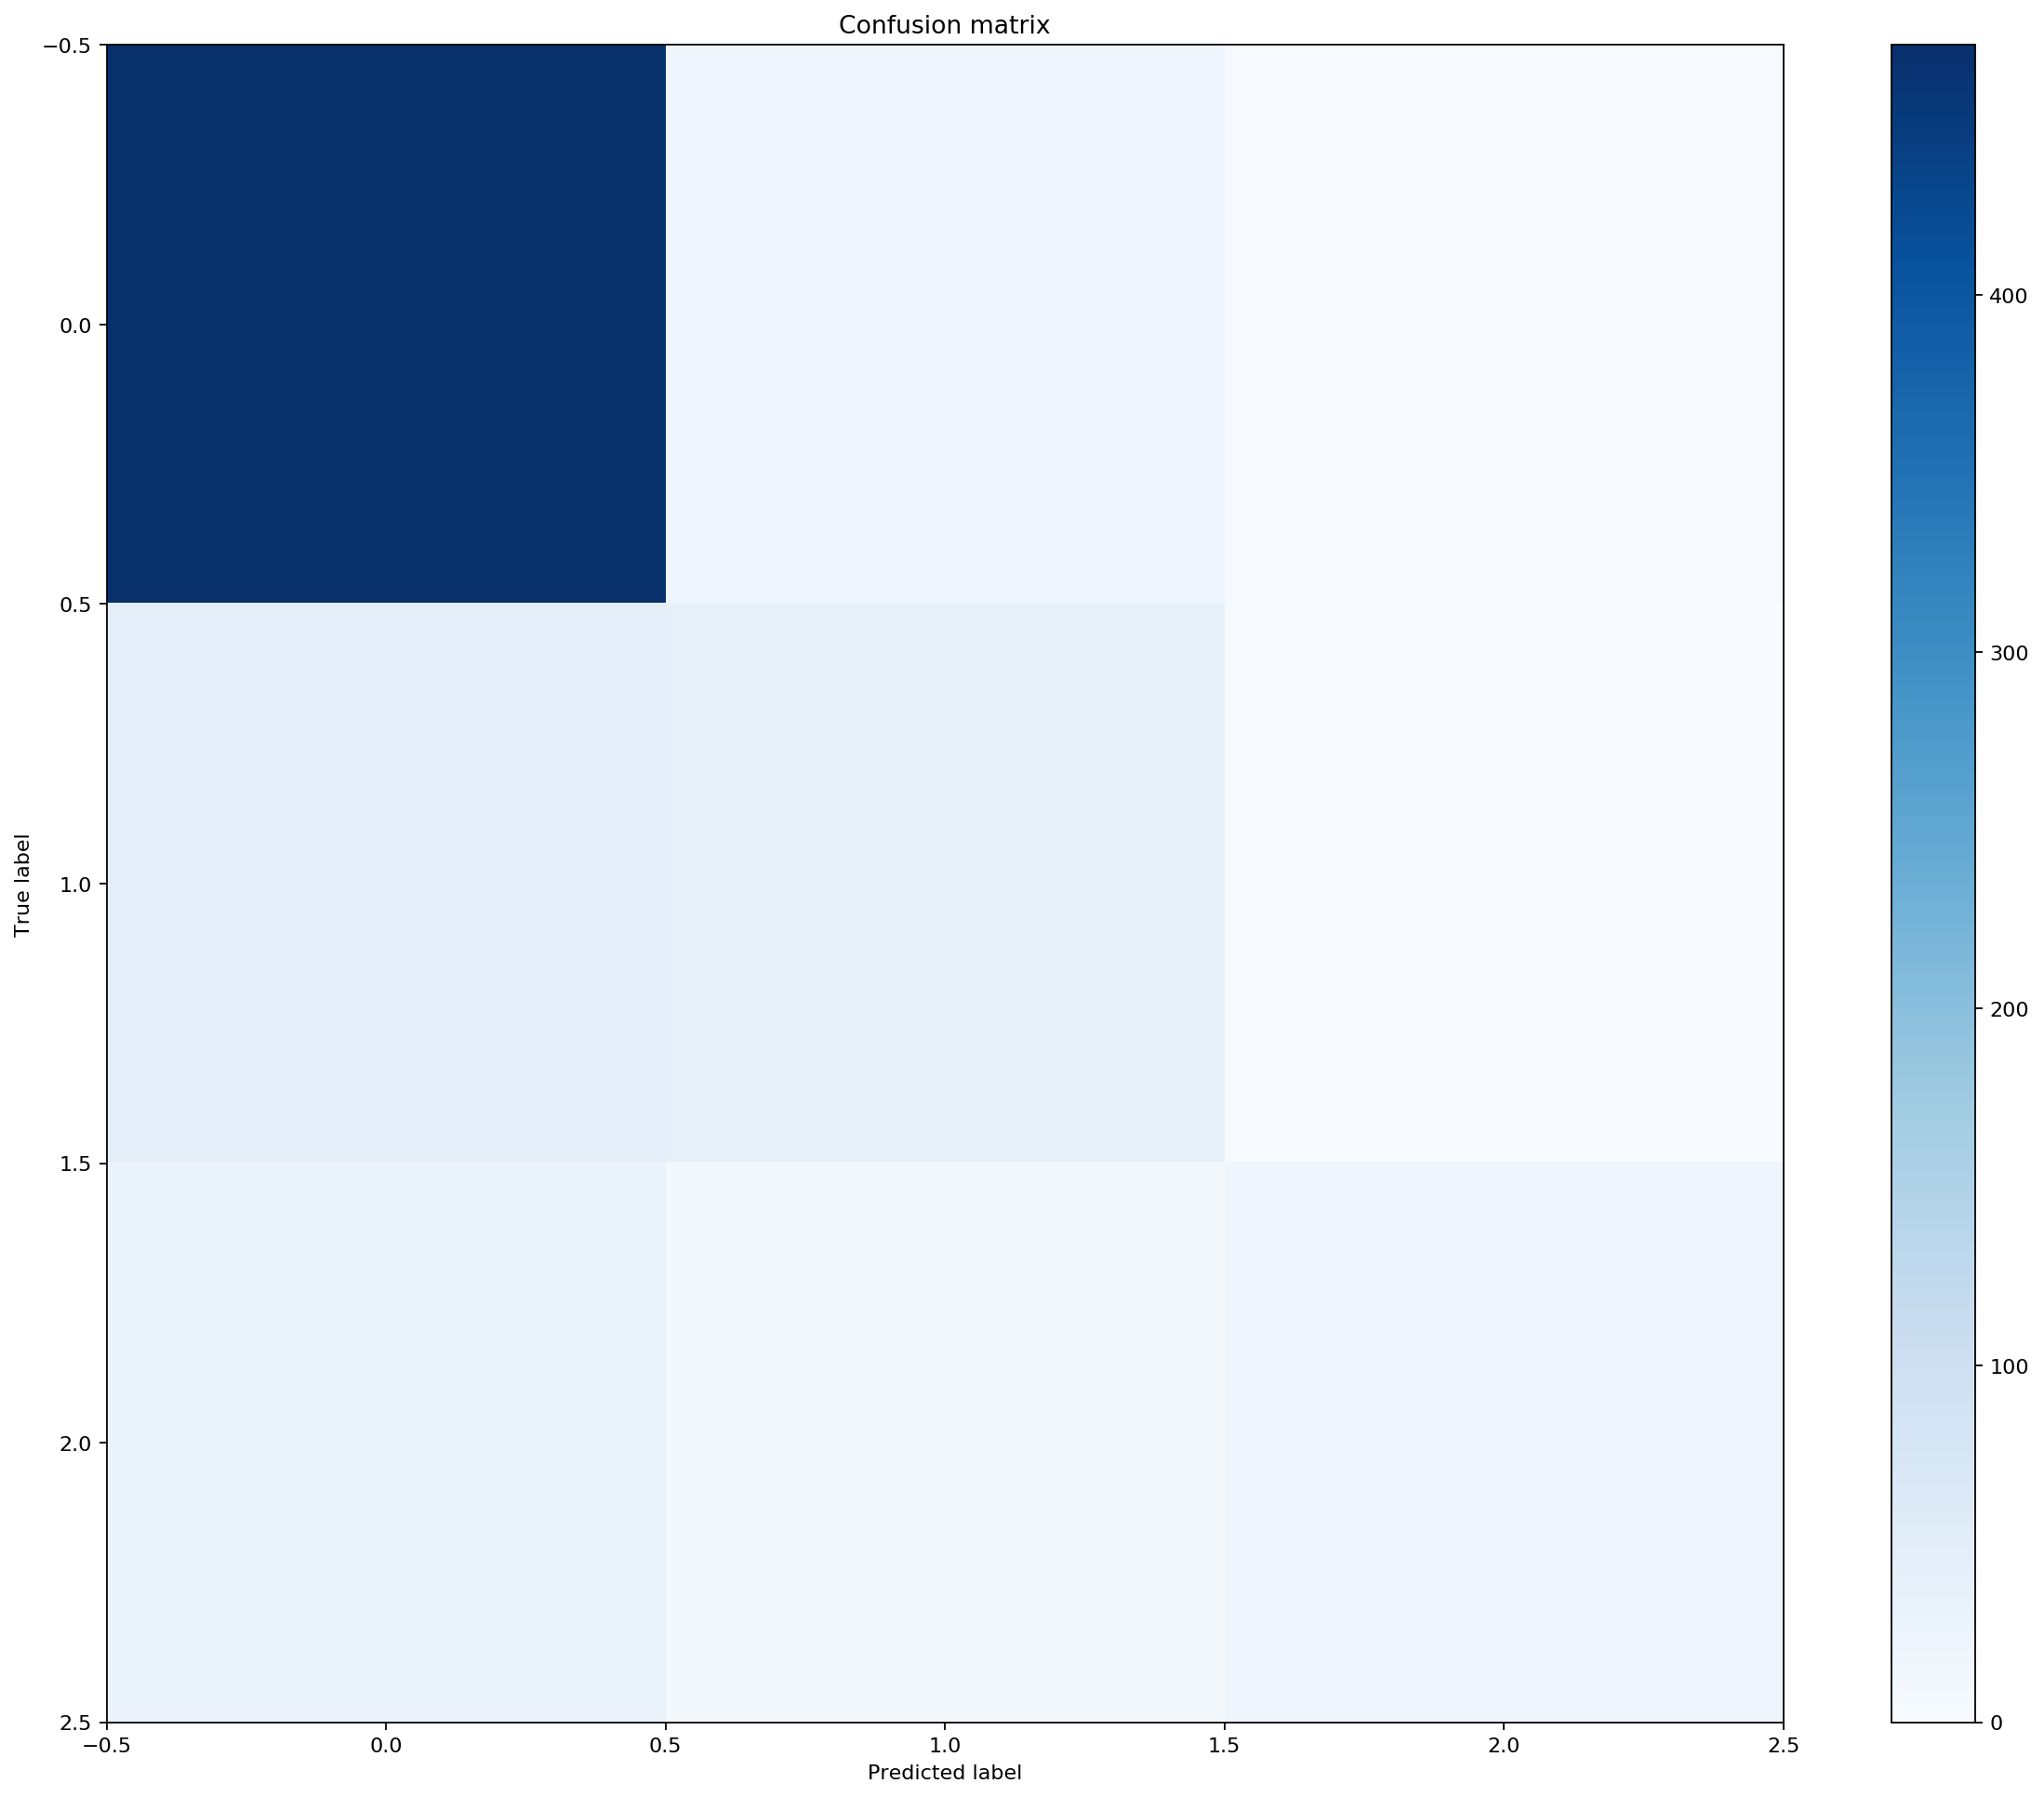

In [92]:
expected = y_test
predicted = classifier.predict(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))


In [93]:
import numpy as np
import time
import datetime as dt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
#fetch original mnist dataset
from sklearn.datasets import fetch_mldata


Start learning at 2018-09-24 03:41:29.176658


Text(0.5,0,'train size')

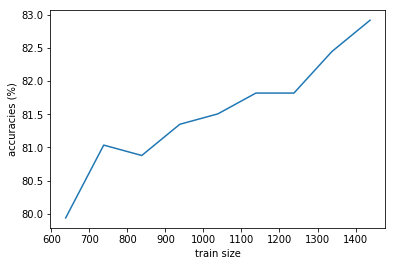

In [94]:
param_C = 5
param_gamma = 0.001

start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

sizes = range(X_test.shape[0], X_train.shape[0], 100)
accuracies = []
for size in sizes:
    classifier = svm.SVC(C=param_C,gamma=param_gamma)
    curXtrain, curYtrain = X_train[:size], y_train[:size]
    classifier.fit(curXtrain, curYtrain)
    expected = y_test
    predicted = classifier.predict(X_test)
    
    accuracies.append(metrics.accuracy_score(expected, predicted) * 100)
plt.plot(sizes, accuracies)
plt.ylabel('accuracies (%)')
plt.xlabel('train size')




Start param searching at 2019-02-10 14:21:50.303828
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=0.1, degree=3, kernel=poly ....................................
[CV] ..................... C=0.1, degree=3, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, kernel=poly ....................................
[CV] ..................... C=0.1, degree=3, kernel=poly, total=   0.0s
[CV] C=0.1, degree=3, kernel=poly ....................................
[CV] ..................... C=0.1, degree=3, kernel=poly, total=   0.0s
[CV] C=0.1, degree=4, kernel=poly ....................................
[CV] ..................... C=0.1, degree=4, kernel=poly, total=   0.0s
[CV] C=0.1, degree=4, kernel=poly ....................................
[CV] ..................... C=0.1, degree=4, kernel=poly, total=   0.0s
[CV] C=0.1, degree=4, kernel=poly ....................................
[CV] ..................... C=0.1, degree=4, kernel=poly, total=   0.0s
[CV] C=0.1, degree=5, kernel=poly .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled 

[CV] ..................... C=0.1, degree=5, kernel=poly, total=   0.0s
[CV] C=0.1, degree=5, kernel=poly ....................................
[CV] ..................... C=0.1, degree=5, kernel=poly, total=   0.0s
[CV] C=0.1, degree=5, kernel=poly ....................................
[CV] ..................... C=0.1, degree=5, kernel=poly, total=   0.0s
[CV] C=0.1, degree=6, kernel=poly ....................................
[CV] ..................... C=0.1, degree=6, kernel=poly, total=   0.0s
[CV] C=0.1, degree=6, kernel=poly ....................................
[CV] ..................... C=0.1, degree=6, kernel=poly, total=   0.0s
[CV] C=0.1, degree=6, kernel=poly ....................................
[CV] ..................... C=0.1, degree=6, kernel=poly, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................
[CV] ..................... C=0.5, degree=3, kernel=poly, total=   0.0s
[CV] C=0.5, degree=3, kernel=poly ....................................
[CV] .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang

[CV] ..................... C=0.5, degree=3, kernel=poly, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] ..................... C=0.5, degree=4, kernel=poly, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] ..................... C=0.5, degree=4, kernel=poly, total=   0.0s
[CV] C=0.5, degree=4, kernel=poly ....................................
[CV] ..................... C=0.5, degree=4, kernel=poly, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ..................... C=0.5, degree=5, kernel=poly, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ..................... C=0.5, degree=5, kernel=poly, total=   0.0s
[CV] C=0.5, degree=5, kernel=poly ....................................
[CV] ..................... C=0.5, degree=5, kernel=poly, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................
[CV] .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang

[CV] ..................... C=0.5, degree=6, kernel=poly, total=   0.0s
[CV] C=0.5, degree=6, kernel=poly ....................................
[CV] ..................... C=0.5, degree=6, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] ..................... C=1.0, degree=3, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] ..................... C=1.0, degree=3, kernel=poly, total=   0.0s
[CV] C=1.0, degree=3, kernel=poly ....................................
[CV] ..................... C=1.0, degree=3, kernel=poly, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................
[CV] ..................... C=1.0, degree=4, kernel=poly, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................
[CV] ..................... C=1.0, degree=4, kernel=poly, total=   0.0s
[CV] C=1.0, degree=4, kernel=poly ....................................
[CV] .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang

[CV] ..................... C=1.0, degree=5, kernel=poly, total=   0.0s
[CV] C=1.0, degree=5, kernel=poly ....................................
[CV] ..................... C=1.0, degree=5, kernel=poly, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ..................... C=1.0, degree=6, kernel=poly, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ..................... C=1.0, degree=6, kernel=poly, total=   0.0s
[CV] C=1.0, degree=6, kernel=poly ....................................
[CV] ..................... C=1.0, degree=6, kernel=poly, total=   0.0s
[CV] C=5.0, degree=3, kernel=poly ....................................
[CV] ..................... C=5.0, degree=3, kernel=poly, total=   0.0s
[CV] C=5.0, degree=3, kernel=poly ....................................
[CV] ..................... C=5.0, degree=3, kernel=poly, total=   0.0s
[CV] C=5.0, degree=3, kernel=poly ....................................
[CV] .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang

[CV] ..................... C=5.0, degree=4, kernel=poly, total=   0.0s
[CV] C=5.0, degree=4, kernel=poly ....................................
[CV] ..................... C=5.0, degree=4, kernel=poly, total=   0.0s
[CV] C=5.0, degree=4, kernel=poly ....................................
[CV] ..................... C=5.0, degree=4, kernel=poly, total=   0.0s
[CV] C=5.0, degree=5, kernel=poly ....................................
[CV] ..................... C=5.0, degree=5, kernel=poly, total=   0.0s
[CV] C=5.0, degree=5, kernel=poly ....................................
[CV] ..................... C=5.0, degree=5, kernel=poly, total=   0.0s
[CV] C=5.0, degree=5, kernel=poly ....................................
[CV] ..................... C=5.0, degree=5, kernel=poly, total=   0.0s
[CV] C=5.0, degree=6, kernel=poly ....................................
[CV] ..................... C=5.0, degree=6, kernel=poly, total=   0.0s
[CV] C=5.0, degree=6, kernel=poly ....................................
[CV] .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang

[CV] ..................... C=5.0, degree=6, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, kernel=poly ...................................
[CV] .................... C=10.0, degree=3, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, kernel=poly ...................................
[CV] .................... C=10.0, degree=3, kernel=poly, total=   0.0s
[CV] C=10.0, degree=3, kernel=poly ...................................
[CV] .................... C=10.0, degree=3, kernel=poly, total=   0.0s
[CV] C=10.0, degree=4, kernel=poly ...................................
[CV] .................... C=10.0, degree=4, kernel=poly, total=   0.0s
[CV] C=10.0, degree=4, kernel=poly ...................................
[CV] .................... C=10.0, degree=4, kernel=poly, total=   0.0s
[CV] C=10.0, degree=4, kernel=poly ...................................
[CV] .................... C=10.0, degree=4, kernel=poly, total=   0.0s
[CV] C=10.0, degree=5, kernel=poly ...................................
[CV] .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang

[CV] .................... C=10.0, degree=5, kernel=poly, total=   0.0s
[CV] C=10.0, degree=5, kernel=poly ...................................
[CV] .................... C=10.0, degree=5, kernel=poly, total=   0.0s
[CV] C=10.0, degree=6, kernel=poly ...................................
[CV] .................... C=10.0, degree=6, kernel=poly, total=   0.0s
[CV] C=10.0, degree=6, kernel=poly ...................................
[CV] .................... C=10.0, degree=6, kernel=poly, total=   0.0s
[CV] C=10.0, degree=6, kernel=poly ...................................
[CV] .................... C=10.0, degree=6, kernel=poly, total=   0.0s
[CV] C=50.0, degree=3, kernel=poly ...................................
[CV] .................... C=50.0, degree=3, kernel=poly, total=   0.0s
[CV] C=50.0, degree=3, kernel=poly ...................................
[CV] .................... C=50.0, degree=3, kernel=poly, total=   0.0s
[CV] C=50.0, degree=3, kernel=poly ...................................
[CV] .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kaiyuewang

[CV] .................... C=50.0, degree=4, kernel=poly, total=   0.0s
[CV] C=50.0, degree=4, kernel=poly ...................................
[CV] .................... C=50.0, degree=4, kernel=poly, total=   0.0s
[CV] C=50.0, degree=4, kernel=poly ...................................
[CV] .................... C=50.0, degree=4, kernel=poly, total=   0.0s
[CV] C=50.0, degree=5, kernel=poly ...................................
[CV] .................... C=50.0, degree=5, kernel=poly, total=   0.0s
[CV] C=50.0, degree=5, kernel=poly ...................................
[CV] .................... C=50.0, degree=5, kernel=poly, total=   0.0s
[CV] C=50.0, degree=5, kernel=poly ...................................
[CV] .................... C=50.0, degree=5, kernel=poly, total=   0.0s
[CV] C=50.0, degree=6, kernel=poly ...................................
[CV] .................... C=50.0, degree=6, kernel=poly, total=   0.0s
[CV] C=50.0, degree=6, kernel=poly ...................................
[CV] .

/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    2.0s finished
/home/kaiyuewang/.virtualenvs/dl4cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


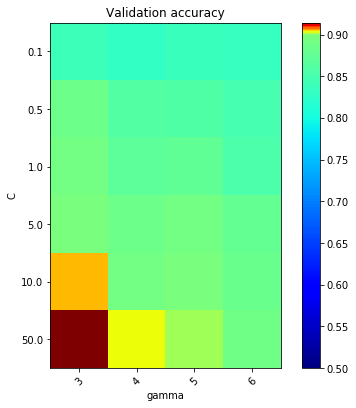

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
from matplotlib.colors import Normalize
# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics, preprocessing
#fetch original mnist dataset

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Z score standardizaition making the dataset zero mean 
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)



############### Classification with grid search ##############
# If you don't want to wait, comment this section and uncommnet section below with
# standalone SVM classifier

# Warning! It takes really long time to compute this about 2 days

# Create parameters grid for RBF kernel, we have to set C and gamma
from sklearn.model_selection import GridSearchCV


# generate matrix with all C
#C_range = np.outer(np.logspace(-3, 3, 7),np.array([1,2, 5]))
C_range = np.outer(np.logspace(-1, 1, 3),np.array([1,5]))
# flatten matrix, change to 1D numpy array
C_range = C_range.flatten()
degree = range(3, 7)

parameters = {'kernel':['poly'], 'C':C_range, 'degree': degree}

svm_clsf = svm.SVC()
grid_clsf = GridSearchCV(estimator=svm_clsf,param_grid=parameters,n_jobs=1, verbose=2)


start_time = dt.datetime.now()
print('Start param searching at {}'.format(str(start_time)))

grid_clsf.fit(X_train, y_train)

elapsed_time= dt.datetime.now() - start_time
print('Elapsed time, param searching {}'.format(str(elapsed_time)))
sorted(grid_clsf.cv_results_.keys())

classifier = grid_clsf.best_estimator_
params = grid_clsf.best_params_



scores = grid_clsf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(degree))

plot_param_space_scores(scores, C_range, degree)

{'C': 50.0, 'degree': 3, 'kernel': 'poly'}
Classification report for classifier SVC(C=50.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       494
         2.0       0.68      0.73      0.70        86
         3.0       0.90      0.81      0.85        58

   micro avg       0.91      0.91      0.91       638
   macro avg       0.84      0.83      0.84       638
weighted avg       0.91      0.91      0.91       638


Confusion matrix:
[[468  22   4]
 [ 22  63   1]
 [  3   8  47]]
Accuracy=0.9059561128526645


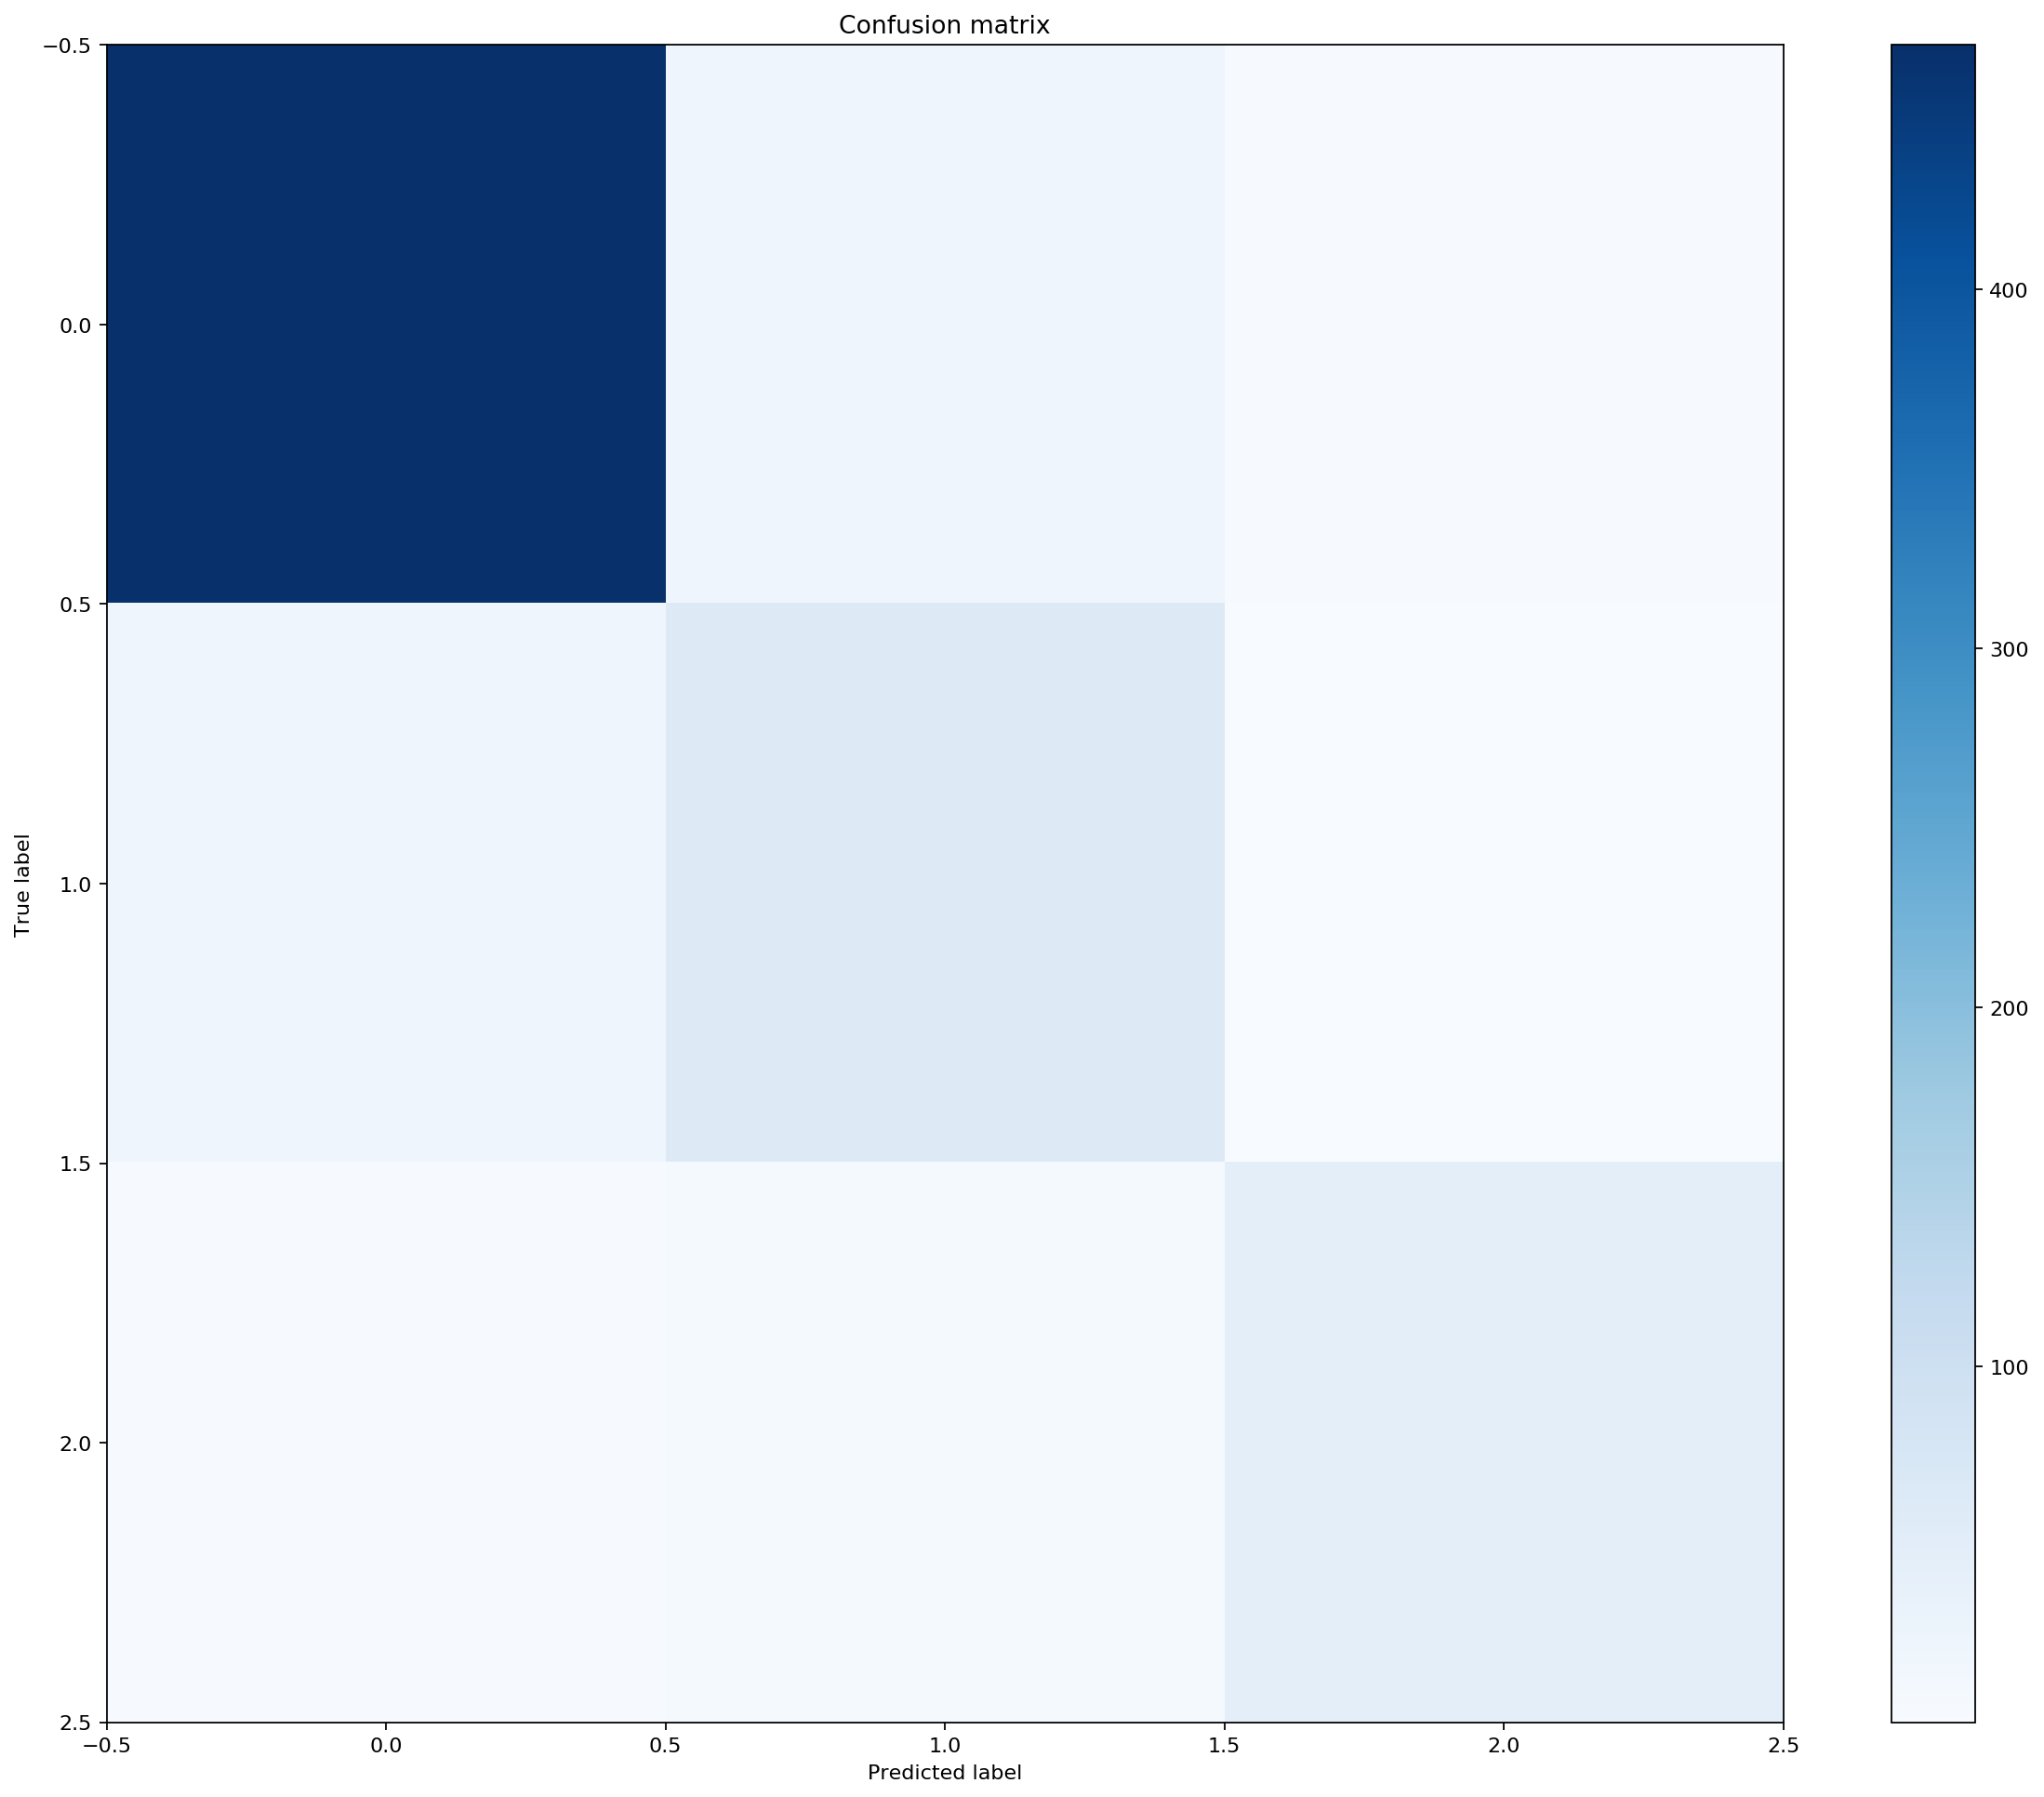

In [21]:
print (params)
expected = y_test
predicted = classifier.predict(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))
